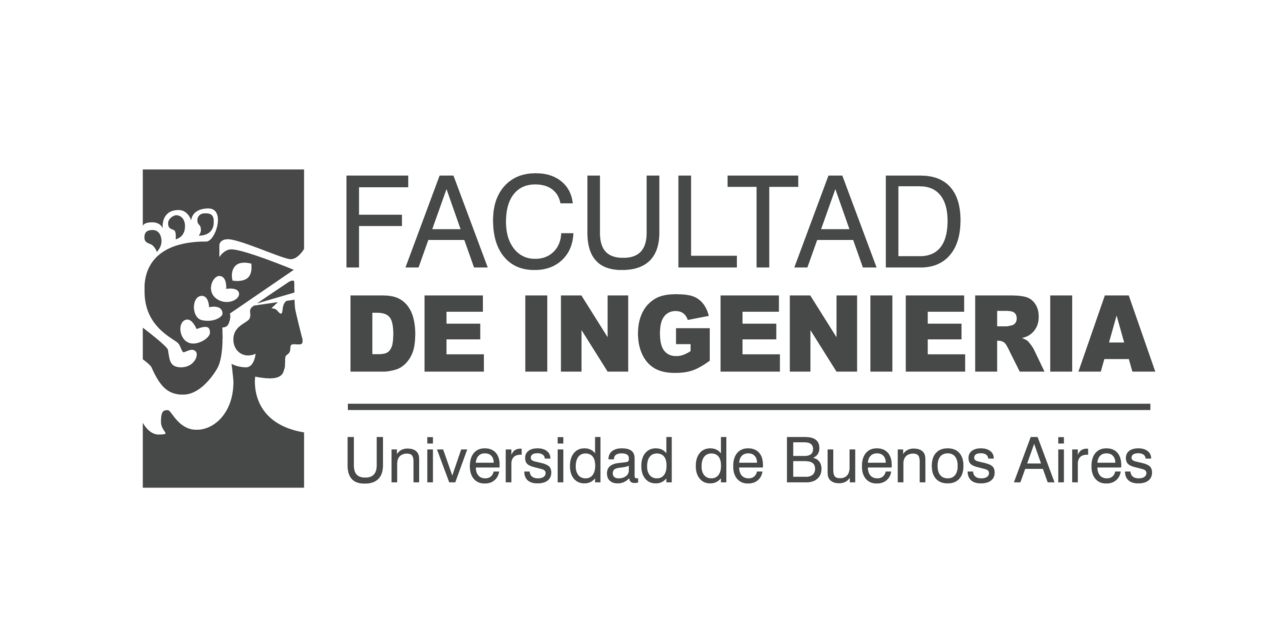
**Profesor:** <br />
Ing. Martín Ignacio Errazquín - merrazquin@fi.uba.ar

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/AMIA-TP3 <br />


# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

## Consigna

## Implementación base

En esta sección se encuentra el codebase sobre el cual se implementan las clases y funciones necesarias para resolver las consignas del trabajo. Hay implementaciones que están dadas y se usaran *as a service* y otras que serán implementadas especialmente (como LDA).

In [55]:
# Aqui se importarán todas las librerías utilizadas en el contexto de este trabajo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, fetch_openml
from sklearn.model_selection import train_test_split


# hiperparámetros
RNG_SEED = 6543
# Dataset test partition size
TEST_SIZE=0.4

### Clases base

#### Bayesian Classifier

In [2]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [3]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

_predict_log_conditional:
return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()
$$\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j^{-1}| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)$$
_predict_one:
return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x
$$\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j^{-1}| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + \log (\pi_j)$$

#### QDA

In [33]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [34]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [35]:
class FasterQDA(TensorizedQDA):
    def _predict_log_conditional(self, x):
        # Calcular las probabilidades para todas las observaciones sin bucles
        #n = X.shape[0]
        log_probs = []

        for class_idx in range(len(self.means)):
            mean = self.means[class_idx]
            inv_cov = self.inv_covs[class_idx]
            
            unbiased_X = x - mean
            # Evitamos la matriz n x n
            # diag(A @ B) = sum(A * B^T) usando broadcasting
            diag_elements = np.sum(unbiased_X.T @ inv_cov * unbiased_X.T, axis=1)
            #diag_elements = np.diagonal(unbiased_X.T @ inv_cov @ unbiased_X)
            log_prob = -0.5 * diag_elements + self.log_a_priori[class_idx]
            log_probs.append(log_prob)

        return np.array(log_probs).T

    def predict(self, X):
        log_probs = self._predict_log_conditional(X)
        return self.encoder.names[np.argmax(log_probs, axis=1)]

#### LDA

In [36]:
class LDA(BaseBayesianClassifier):
    def _fit_params(self, X, y):
        n_features, n_samples = X.shape
        n_classes = len(self.encoder.names)
        # Calcular las medias para cada clase
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True) 
                       for idx in range(n_classes)]
        
        # Inicializar la matriz de covarianza común
        #self.shared_cov = np.zeros((n_features, n_features))
        shared_cov = np.zeros((n_features, n_features))

        # Calcular la matriz de covarianza común
        for idx in range(n_classes):
            class_samples = X[:, y.flatten() == idx]
            cov = np.cov(class_samples, bias=True)
            shared_cov += cov * class_samples.shape[1]
        # Normalizar la matriz de covarianza común
        shared_cov /= n_samples  # Divide por el número total de muestras
        # Invertir la matriz de covarianza
        self.inv_cov = inv(shared_cov)

    def _predict_log_conditional(self, x, class_idx):
        # Predecir log(P(x|G=class_idx)), el logaritmo de la probabilidad condicional de x dada la clase
        unbiased_x = x - 0.5 * self.means[class_idx]
        #log_p_conditional = (0.5 * np.log(det(self.inv_cov)) - 0.5 * (unbiased_x.T @ self.inv_cov @ unbiased_x))
        log_p_conditional = self.means[class_idx].T @ self.inv_cov @ unbiased_x
        return log_p_conditional

In [37]:
class TensorizedLDA(LDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        #self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        #unbiased_x = x - self.tensor_means
        unbiased_x = x - 0.5 * self.tensor_means
        inv_cov_unbiased_x = self.inv_cov @ unbiased_x
        #print(self.tensor_means.transpose(0,2,1).shape)
        #print(inv_cov_unbiased_x.shape)
        #inner_prod = unbiased_x.transpose(0,2,1) @ self.inv_cov @ unbiased_x  
        z = self.tensor_means.transpose(0,2,1) @ inv_cov_unbiased_x
        #print(z.flatten())
        #print(type(z))
        return z.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [38]:
class FasterLDA(TensorizedLDA):
    def _predict_log_conditional(self, x):
        # Calcular las probabilidades para todas las observaciones sin bucles
        log_probs = []

        for class_idx in range(len(self.means)):
            mean = self.means[class_idx]
            
            unbiased_X = x - mean
            # Evitamos la matriz n x n
            # diag(A @ B) = sum(A * B^T) usando broadcasting
            diag_elements = np.sum(unbiased_X.T @ self.inv_cov * unbiased_X.T, axis=1)
            #diag_elements = np.diagonal(unbiased_X.T @ self.inv_cov @ unbiased_X)
            log_prob = -0.5 * diag_elements + self.log_a_priori[class_idx]
            log_probs.append(log_prob)

        return np.array(log_probs).T

    def predict(self, X):
        log_probs = self._predict_log_conditional(X)
        return self.encoder.names[np.argmax(log_probs, axis=1)]

### Preparación: Dataset loaders

Se agrega bool flag para plot de distribución de dataset para etapa de exploración.

In [56]:
def get_iris_dataset(plot: bool = False):
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])

  if plot:
      _, ax = plt.subplots()
      scatter = ax.scatter(data.data[:, 0], data.data[:, 1], c=data.target)
      ax.set(xlabel=data.feature_names[0], ylabel=data.feature_names[1])
      _ = ax.legend( scatter.legend_elements()[0], data.target_names, loc="lower right", title="Classes")
  
  return X_full, y_full

def get_penguins(plot: bool = False):
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')
    
    # Agregar la columna de la especie (target) al DataFrame
    aux = df.copy()
    aux['species'] = tgt

    if plot:
        # Crear un scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=aux, x='culmen_length_mm', y='flipper_length_mm', hue='species', style='species', s=80)
        plt.title('Relación entre longitud del culmen y longitud de la aleta por especie')
        plt.xlabel('Longitud del culmen (mm)')
        plt.ylabel('Longitud de la aleta (mm)')
        plt.legend(title='Especie')
        plt.show()

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

def plot_classes_penguins():
    # Cargar dataset de penguins desde seaborn
    penguins = sns.load_dataset("penguins")
    
    # Verificar si hay datos nulos
    penguins.dropna(subset=['species'], inplace=True)
    
    # Graficar la distribución de clases
    plt.figure(figsize=(6, 4))
    sns.countplot(data=penguins, x='species')
    plt.title('Distribución de Clases en el Dataset de Penguins')
    plt.xlabel('Especie')
    plt.ylabel('Cantidad')
    plt.show()

def plot_classes_iris():
    # Load Iris dataset
    iris = load_iris()
    data = pd.DataFrame(iris.data, columns=iris.feature_names)
    data['species'] = iris.target
    print(f'Size of dataset: {len(data)}')
    
    # Map target integers to species names
    species_mapping = dict(zip(range(3), iris.target_names))
    data['species'] = data['species'].map(species_mapping)
    
    # Plot the class distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x='species')
    plt.title('Distribución de clases en dataset Iris')
    plt.xlabel('Especies')
    plt.ylabel('Cantidad')
    plt.show()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

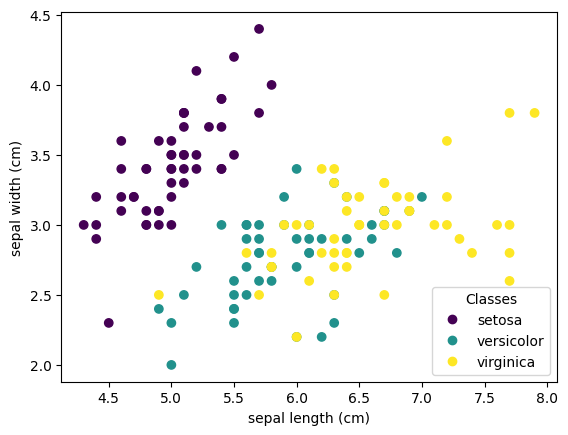

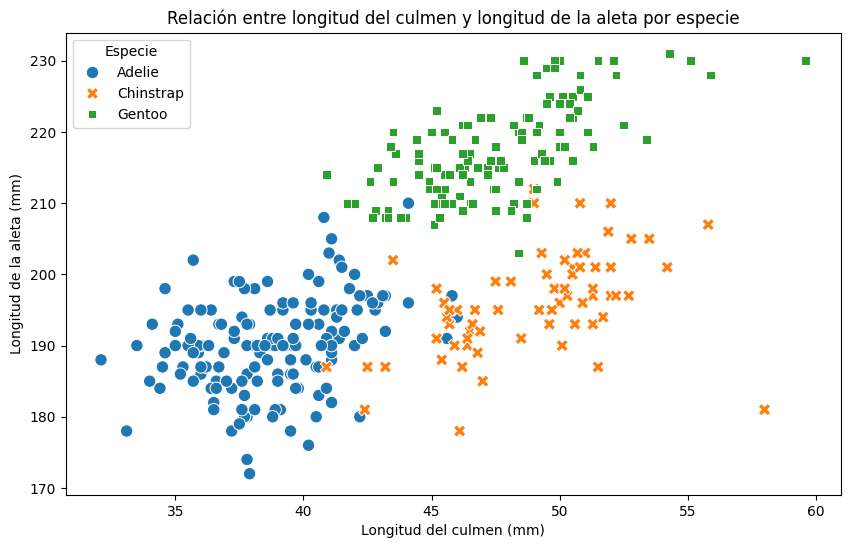

Shapes for iris dataset - X: (150, 4), Y:(150, 1)
Shapes for iris penguins - X: (150, 4), Y:(342, 1)


In [16]:
# showing for iris
X_full_iris, y_full_iris = get_iris_dataset(plot=True)
X_full_penguin, y_full_penguin = get_penguins(plot=True)

print(f"Shapes for iris dataset - X: {X_full_iris.shape}, Y:{y_full_iris.shape}")
print(f"Shapes for iris penguins - X: {X_full_iris.shape}, Y:{y_full_penguin.shape}")


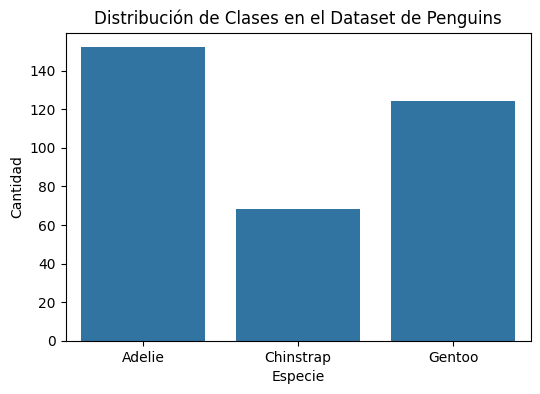

Size of dataset: 150


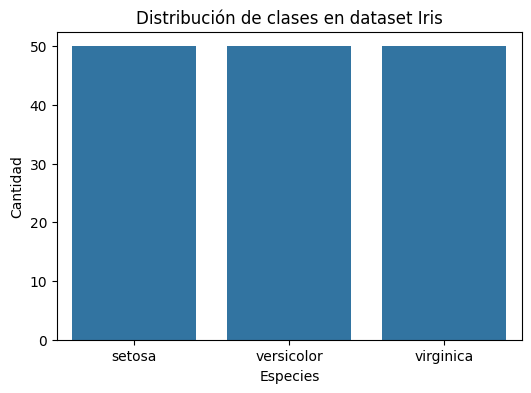

In [17]:
plot_classes_penguins()
plot_classes_iris()


### Preparación: Dataset split

In [20]:
def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

In [21]:
train_x_iris, train_y_iris, test_x_iris, test_y_iris = split_transpose(X_full_iris, y_full_iris, TEST_SIZE, RNG_SEED)
train_x_penguin, train_y_penguin, test_x_penguin, test_y_penguin = split_transpose(X_full_penguin, y_full_penguin, TEST_SIZE, RNG_SEED)

print("IRIS DATASET")
display(train_x_iris.shape, train_y_iris.shape, test_x_iris.shape, test_y_iris.shape)
print("PENGUIN DATASET")
display(train_x_penguin.shape, train_y_penguin.shape, test_x_penguin.shape, test_y_penguin.shape)

IRIS DATASET


(4, 90)

(1, 90)

(4, 60)

(1, 60)

PENGUIN DATASET


(4, 205)

(1, 205)

(4, 137)

(1, 137)

Entrenamos un QDA y medimos su accuracy

## Consigna 1: Implementación base

Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.

### 1.1 Uniforme (cada clase tiene probabilidad 1/3)


In [39]:
# without a priori distributions
print(f'### WITHOUT A PRIORI ###')
qda = QDA()
qda.fit(train_x_iris, train_y_iris)
train_acc = accuracy(train_y_iris, qda.predict(train_x_iris))
test_acc = accuracy(test_y_iris, qda.predict(test_x_iris))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

# a priori distributions
print(f'### A PRIORI [1/3,1/3,1/3] ###')
qda.fit(train_x_iris, train_y_iris, a_priori= np.array([1/3, 1/3, 1/3]))
train_acc = accuracy(train_y_iris, qda.predict(train_x_iris))
test_acc = accuracy(test_y_iris, qda.predict(test_x_iris))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

### WITHOUT A PRIORI ###
Train (apparent) error is 0.0111 while test error is 0.0167
### A PRIORI [1/3,1/3,1/3] ###
Train (apparent) error is 0.0222 while test error is 0.0167


In [40]:
%%timeit
qda.predict(test_x_iris)

2.01 ms ± 39.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%%timeit
model = QDA()
model.fit(train_x_iris, train_y_iris)
model.predict(test_x_iris)

2.21 ms ± 71.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 1.2 Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)

In [42]:
# a priori distributions
print(f'### A PRIORI [0.9, 0.05, 0.05] ###')
qda.fit(train_x_iris, train_y_iris, a_priori= np.array([0.9, 0.05, 0.05]))
train_acc = accuracy(train_y_iris, qda.predict(train_x_iris))
test_acc = accuracy(test_y_iris, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

print(f'### A PRIORI [0.05, 0.9, 0.05] ###')
qda.fit(train_x_iris, train_y_iris, a_priori= np.array([0.05, 0.9, 0.05]))
train_acc = accuracy(train_y_iris, qda.predict(train_x_iris))
test_acc = accuracy(test_y_iris, qda.predict(test_x_iris))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

print(f'### A PRIORI [0.05, 0.05, 0.9] ###')
qda.fit(train_x_iris, train_y_iris, a_priori= np.array([0.05, 0.05, 0.9]))
train_acc = accuracy(train_y_iris, qda.predict(train_x_iris))
test_acc = accuracy(test_y_iris, qda.predict(test_x_iris))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

### A PRIORI [0.9, 0.05, 0.05] ###
Train (apparent) error is 0.0222 while test error is 0.0167
### A PRIORI [0.05, 0.9, 0.05] ###
Train (apparent) error is 0.0333 while test error is 0.0000
### A PRIORI [0.05, 0.05, 0.9] ###
Train (apparent) error is 0.0333 while test error is 0.0500


In [32]:
def _estimate_a_priori(y, full: bool = False):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    print(f"Train split dataset: {a_priori}" if not full else f"Full dataset: {a_priori}")
    print(f"Train split dataset: {np.log(a_priori)}" if not full else f"Full dataset: {np.log(a_priori)}")
    return np.log(a_priori)
    
a_priori = None 
encoder = ClassEncoder()
y_full = encoder.fit_transform(y_full_iris)
y_train_split = encoder.fit_transform(train_y_iris)

log_a_priori_full = _estimate_a_priori(y_full, full=True) if a_priori is None else np.log(a_priori)
log_a_priori_train = _estimate_a_priori(y_train_split) if a_priori is None else np.log(a_priori)

a_priori = [1/3, 1/3, 1/3]
log_a_priori = _estimate_a_priori(y_train_split) if a_priori is None else np.log(a_priori)

print(f"A priori [1/3, 1/3, 1/3]: {log_a_priori}")

Full dataset: [0.33333333 0.33333333 0.33333333]
Full dataset: [-1.09861229 -1.09861229 -1.09861229]
Train split dataset: [0.3        0.32222222 0.37777778]
Train split dataset: [-1.2039728  -1.13251384 -0.97344915]
A priori [1/3, 1/3, 1/3]: [-1.09861229 -1.09861229 -1.09861229]


Da distinto accuracy por que la distribución en las particiones de test y train de las clases no se mantiene igual que en el dataset full. 

In [55]:
%%timeit
qda.predict(test_x)

2.01 ms ± 109 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%%timeit
model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

2.18 ms ± 238 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 2: Repetir el punto anterior para el dataset *penguin*.

In [51]:
qda = QDA()
qda.fit(train_x_penguin, train_y_penguin)

print('### DATASET PENGUIN ###')


train_acc = accuracy(train_y_penguin, qda.predict(train_x_penguin))
test_acc = accuracy(train_y_penguin, qda.predict(train_x_penguin))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

# a priori distributions
print(f'### A PRIORI [1/3, 1/3, 1/3] ###')
qda.fit(train_x_penguin, train_y_penguin, a_priori= np.array([1/3, 1/3, 1/3]))
train_acc = accuracy(train_y_penguin, qda.predict(train_x_penguin))
test_acc = accuracy(test_y_penguin, qda.predict(test_x_penguin))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

print(f'### A PRIORI [0.9, 0.05, 0.05] ###')
qda.fit(train_x_penguin, train_y_penguin, a_priori= np.array([0.9, 0.05, 0.05]))
train_acc = accuracy(train_y_penguin, qda.predict(train_x_penguin))
test_acc = accuracy(test_y_penguin, qda.predict(test_x_penguin))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

print(f'### A PRIORI [0.05, 0.9, 0.05] ###')
qda.fit(train_x_penguin, train_y_penguin, a_priori= np.array([0.05, 0.9, 0.05]))
train_acc = accuracy(train_y_penguin, qda.predict(train_x_penguin))
test_acc = accuracy(test_y_penguin, qda.predict(test_x_penguin))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

print(f'### A PRIORI [0.05, 0.05, 0.9] ###')
qda.fit(train_x_penguin, train_y_penguin, a_priori= np.array([0.05, 0.05, 0.9]))
train_acc = accuracy(train_y_penguin, qda.predict(train_x_penguin))
test_acc = accuracy(test_y_penguin, qda.predict(test_x_penguin))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

### DATASET PENGUIN ###
Train (apparent) error is 0.0146 while test error is 0.0146
### A PRIORI [1/3, 1/3, 1/3] ###
Train (apparent) error is 0.0098 while test error is 0.0073
### A PRIORI [0.9, 0.05, 0.05] ###
Train (apparent) error is 0.0195 while test error is 0.0219
### A PRIORI [0.05, 0.9, 0.05] ###
Train (apparent) error is 0.0098 while test error is 0.0219
### A PRIORI [0.05, 0.05, 0.9] ###
Train (apparent) error is 0.0098 while test error is 0.0073


In [52]:
%%timeit
qda.predict(test_x_penguin)

4.83 ms ± 101 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
%%timeit
model = QDA()
model.fit(train_x_penguin, train_y_penguin)
model.predict(test_x_penguin)

4.46 ms ± 80.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 3: Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?

* Se calcula
* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra (dada por la clase BaseBayesianClassifier)
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*
    * En np.cov(class_samples, rowvar=False, bias=True), el argumento bias=True asegura que se está utilizando el estimador de máxima verosimilitud. Este estimador divide por $n_j$ (en lugar de $n_j - 1$), que corresponde a la fórmula de máxima verosimilitud y no es insesgado

In [61]:
# Se instancia el modelo LDA implementado en la sección Clases Base - LDA
lda = LDA()

### IRIS DATASET ###
Train (apparent) error is 0.0222 while test error is 0.0167


,True Label,Predicted Label
51,versicolor,virginica


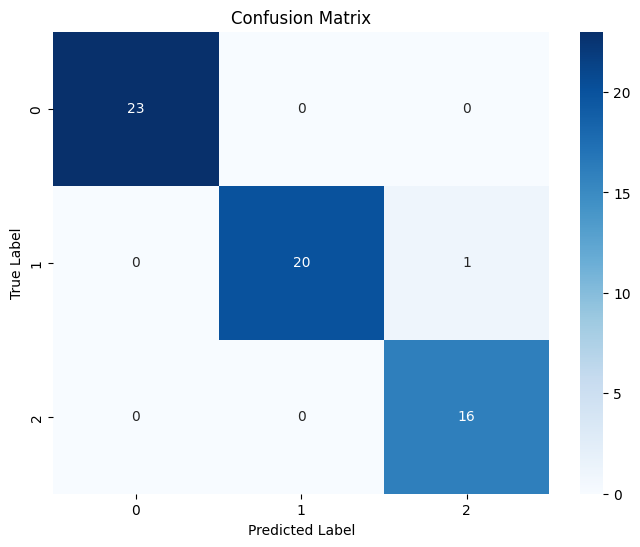

In [62]:
# IRIS DATASET
print("### IRIS DATASET ###")
lda.fit(train_x_iris, train_y_iris)

train_acc = accuracy(train_y_iris, lda.predict(train_x_iris))
test_acc = accuracy(test_y_iris, lda.predict(test_x_iris))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

# CONFUSION MATRIX
test_y_flatten = test_y_iris.flatten()
test_x_flatten = lda.predict(test_x_iris).flatten()

df_compare = pd.DataFrame({'True Label': test_y_flatten, 'Predicted Label': test_x_flatten})
display(df_compare[df_compare['True Label'] != df_compare['Predicted Label']])

# Calcular la matriz de confusión
cm = confusion_matrix(test_y_flatten, test_x_flatten)
plot_confusion_matrix(cm=cm)

### PENGUIN DATASET ###
Train (apparent) error is 0.0098 while test error is 0.0146


,True Label,Predicted Label
29,Chinstrap,Adelie
51,Chinstrap,Adelie


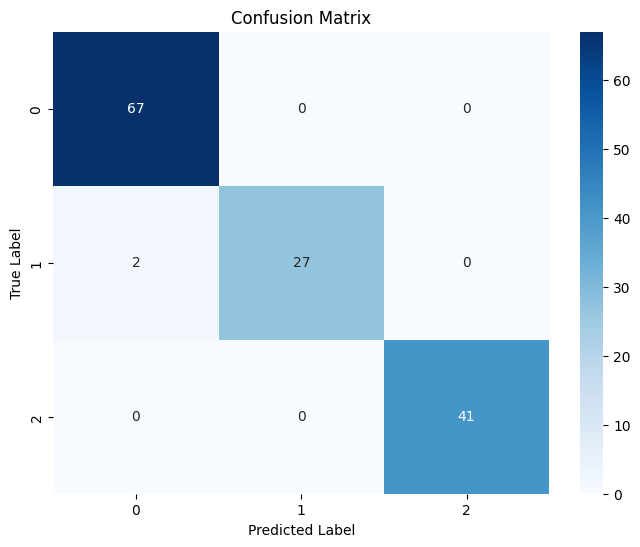

In [63]:
# PENGUIN DATASET
print("### PENGUIN DATASET ###")
lda.fit(train_x_penguin, train_y_penguin)

train_acc = accuracy(train_y_penguin, lda.predict(train_x_penguin))
test_acc = accuracy(test_y_penguin, lda.predict(test_x_penguin))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

# CONFUSION MATRIX
test_y_flatten = test_y_penguin.flatten()
test_x_flatten = lda.predict(test_x_penguin).flatten()

df_compare = pd.DataFrame({'True Label': test_y_flatten, 'Predicted Label': test_x_flatten})
display(df_compare[df_compare['True Label'] != df_compare['Predicted Label']])

# Calcular la matriz de confusión
cm = confusion_matrix(test_y_flatten, test_x_flatten)
plot_confusion_matrix(cm=cm)



In [64]:
%%timeit

lda.predict(test_x_iris)

1.05 ms ± 22.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [65]:
%%timeit

model = LDA()
model.fit(train_x_iris, train_y_iris)
model.predict(test_x_iris)

1.36 ms ± 10.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 4: Utilizar otros 2 (dos) valores de random seed para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?

### 5: Estimar y comparar los tiempos de predicción de las clases QDA y TensorizedQDA. De haber diferencias ¿Cuáles pueden ser las causas?

## Consigna 2: Optimización Matemática

### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

## Consigna 3: Preguntas Teóricas

## Consigna 4: Ejercicio Teórico

## Anexo Teoría

### Definición Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.


## Anexo Persistencia y Análisis de datos

Dado que la idea de entrenar distintos modelos es poder comparar su performance tanto en términos de calidad de predicciones como en tiempo de ejecución y utilización de memoria es que se decidió utilizar una base de datos relacional externa para persistir todas las corridas de los modelos y poder realizar el análisis facilmente.

PLACEHOLDER: Acá va diagrama y explicación de como obtenemos los datos y como los analizamos.

Luego, generar plots con el analisis de los datos y las comparativas.

TODO: Agregar metrica de memoria que no se esta calculando.

Modelo de datos:

- Model Name
- Seed
- Test Error
- Train Error
- Test Accuracy
- Train Accuracy 
- Dataset
